In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam
from IPython import display

%matplotlib inline
%load_ext tensorboard
%load_ext pycodestyle_magic

In [2]:
%flake8_on --max_line_length 115

BUFFER_SIZE = 1000
BATCH_SIZE = 30
NOISE_DIM = 100
EPOCHS = 12
NUM_EXAMPLES = 16

seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

In [3]:
(images, labels), _ = tf.keras.datasets.mnist.load_data()
images = images.reshape([images.shape[0], 28, 28, 1])
images = tf.image.convert_image_dtype(images, tf.float32) * 2 - 1

train_ds = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model


generator = make_generator_model()
discriminator = make_discriminator_model()

tf.Tensor([[-0.00123161]], shape=(1, 1), dtype=float32)


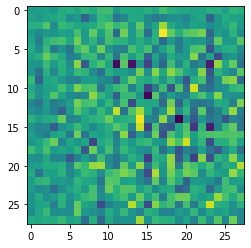

In [5]:
noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image)

plt.imshow(tf.squeeze(generated_image), cmap='viridis')
print(decision)

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_pred, fake_pred):
    real_loss = cross_entropy(tf.ones_like(real_pred), real_pred)
    fake_loss = cross_entropy(tf.zeros_like(fake_pred), fake_pred)

    return real_loss + fake_loss


def generator_loss(fake_pred):
    return cross_entropy(tf.ones_like(fake_pred), fake_pred)

In [7]:
checkpoint_dir = './GAN_checkpoints'
checkpoint_prex = checkpoint_dir + '/ckpt'

generator_optimizer = Adam(1e-4)
discrimator_optimizer = Adam(1e-4)

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discrimator_optimizer=discrimator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [8]:
@tf.function
def train_step(real_images):

    noise = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_pred = discriminator(real_images, training=True)
        fake_pred = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_pred)
        disc_loss = discriminator_loss(real_pred, fake_pred)

        gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
        discrimator_optimizer.apply_gradients(zip(disc_grad, discriminator.trainable_variables))

        return gen_loss, disc_loss

In [9]:
def generate_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [10]:
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)

        print('=> Time for epoch {:02d} is {:.3f} secs'.format(epoch, time.time() - start))
        print('Generator loss {} Discriminator loss {}'.format(gen_loss, disc_loss))
        if epoch % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prex)

        display.clear_output(wait=True)
        generate_save_images(generator, epoch, seed)

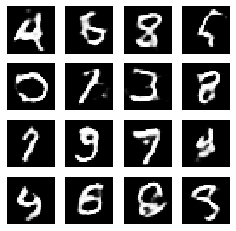

CPU times: user 37min 32s, sys: 13min 33s, total: 51min 6s
Wall time: 8min 25s


In [11]:
%%time
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(train_ds, EPOCHS)